In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! mkdir ~/.kaggle

In [ ]:
cp  /content/drive/MyDrive/Kaggle_Api/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [16]:
! kaggle datasets download patrickb1912/ipl-complete-dataset-20082020

Dataset URL: https://www.kaggle.com/datasets/patrickb1912/ipl-complete-dataset-20082020
License(s): DbCL-1.0


In [18]:
! unzip ipl-complete-dataset-20082020.zip

Archive:  ipl-complete-dataset-20082020.zip
  inflating: deliveries.csv          
  inflating: matches.csv             


# **Step 1: Data Loading and Initial Exploration**

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cricket_df = pd.read_csv('deliveries.csv')
# Let's examine the basic properties of the dataset

# Display the first few rows
print("First 5 rows:")
print(cricket_df.head())

# Dataset dimensions
print("\nDataset dimensions:", cricket_df.shape)

# Check data types
print("\nData types:")
print(cricket_df.dtypes)

# Check for missing values
print("\nMissing values per column:")
print(cricket_df.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
print(cricket_df.describe())

First 5 rows:
   match_id  inning           batting_team                 bowling_team  over  \
0    335982       1  Kolkata Knight Riders  Royal Challengers Bangalore     0   
1    335982       1  Kolkata Knight Riders  Royal Challengers Bangalore     0   
2    335982       1  Kolkata Knight Riders  Royal Challengers Bangalore     0   
3    335982       1  Kolkata Knight Riders  Royal Challengers Bangalore     0   
4    335982       1  Kolkata Knight Riders  Royal Challengers Bangalore     0   

   ball       batter   bowler  non_striker  batsman_runs  extra_runs  \
0     1   SC Ganguly  P Kumar  BB McCullum             0           1   
1     2  BB McCullum  P Kumar   SC Ganguly             0           0   
2     3  BB McCullum  P Kumar   SC Ganguly             0           1   
3     4  BB McCullum  P Kumar   SC Ganguly             0           0   
4     5  BB McCullum  P Kumar   SC Ganguly             0           0   

   total_runs extras_type  is_wicket player_dismissed dismissal_ki

# **Step 2: Data Cleaning**

In [22]:
# Convert columns to appropriate data types
cricket_df['match_id'] = cricket_df['match_id'].astype(int)
cricket_df['inning'] = cricket_df['inning'].astype(int)
cricket_df['over'] = cricket_df['over'].astype(int)
cricket_df['ball'] = cricket_df['ball'].astype(int)
cricket_df['batsman_runs'] = cricket_df['batsman_runs'].astype(int)
cricket_df['extra_runs'] = cricket_df['extra_runs'].astype(int)
cricket_df['total_runs'] = cricket_df['total_runs'].astype(int)
cricket_df['is_wicket'] = cricket_df['is_wicket'].astype(int)

# Handle missing values appropriately
# For dismissal fields, missing values are expected when no wicket falls
cricket_df['extras_type'] = cricket_df['extras_type'].fillna('none')

# Create a ball_id column for unique delivery identification
cricket_df['ball_id'] = cricket_df['match_id'].astype(str) + "_" + \
                         cricket_df['inning'].astype(str) + "_" + \
                         cricket_df['over'].astype(str) + "_" + \
                         cricket_df['ball'].astype(str)

# **Step 3: Feature Engineering**

In [23]:
# Add a column for boundaries
cricket_df['is_four'] = (cricket_df['batsman_runs'] == 4).astype(int)
cricket_df['is_six'] = (cricket_df['batsman_runs'] == 6).astype(int)

# Add a column for dot balls (no runs from bat)
cricket_df['is_dot'] = ((cricket_df['batsman_runs'] == 0) &
                        (cricket_df['extras_type'].isin(['none', 'legbyes', 'byes']))).astype(int)

# Calculate over number in the match (combines innings and over)
cricket_df['match_over'] = (cricket_df['inning'] - 1) * 20 + cricket_df['over']

# Create a phase column (PowerPlay: 0-5, Middle: 6-15, Death: 16-19)
conditions = [
    cricket_df['over'] <= 5,
    (cricket_df['over'] >= 6) & (cricket_df['over'] <= 15),
    cricket_df['over'] >= 16
]
choices = ['PowerPlay', 'Middle', 'Death']
cricket_df['phase'] = np.select(conditions, choices, default='Unknown')

# **Step 4: Team Performance Analysis**

In [24]:
# Calculate team-wise performance metrics
team_batting = cricket_df.groupby('batting_team').agg({
    'total_runs': 'sum',
    'is_wicket': 'sum',
    'is_four': 'sum',
    'is_six': 'sum',
    'is_dot': 'sum',
    'ball_id': 'count'
}).reset_index()

# Calculate batting statistics
team_batting['batting_avg'] = team_batting['total_runs'] / team_batting['is_wicket'].replace(0, 1)
team_batting['batting_sr'] = (team_batting['total_runs'] / team_batting['ball_id']) * 100
team_batting['boundary_percentage'] = ((team_batting['is_four'] + team_batting['is_six']) / team_batting['ball_id']) * 100
team_batting['dot_percentage'] = (team_batting['is_dot'] / team_batting['ball_id']) * 100

print("Team Batting Performance:")
print(team_batting.sort_values('batting_sr', ascending=False))

# Calculate bowling statistics
team_bowling = cricket_df.groupby('bowling_team').agg({
    'total_runs': 'sum',
    'is_wicket': 'sum',
    'ball_id': 'count'
}).reset_index()

team_bowling['economy_rate'] = (team_bowling['total_runs'] / team_bowling['ball_id']) * 6
team_bowling['bowling_avg'] = team_bowling['total_runs'] / team_bowling['is_wicket'].replace(0, 1)
team_bowling['bowling_sr'] = team_bowling['ball_id'] / team_bowling['is_wicket'].replace(0, 1)

print("\nTeam Bowling Performance:")
print(team_bowling.sort_values('economy_rate'))

Team Batting Performance:
                   batting_team  total_runs  is_wicket  is_four  is_six  \
17  Royal Challengers Bengaluru        2930         99      229     165   
5                Gujarat Titans        7757        247      691     271   
12                 Punjab Kings        9536        371      795     440   
9          Lucknow Super Giants        7510        276      577     332   
4                 Gujarat Lions        4862        188      460     155   
2                Delhi Capitals       14900        570     1352     550   
0           Chennai Super Kings       38629       1245     3196    1509   
10               Mumbai Indians       42176       1573     3637    1685   
16  Royal Challengers Bangalore       37692       1384     3149    1488   
8         Kolkata Knight Riders       39331       1491     3461    1495   
18          Sunrisers Hyderabad       29071       1058     2405    1042   
6               Kings XI Punjab       30064       1158     2631    1075   

# **Step 5: Player Performance Analysis**

In [25]:
# Batsmen analysis
batsmen = cricket_df.groupby('batter').agg({
    'batsman_runs': 'sum',
    'is_wicket': 'sum',
    'is_four': 'sum',
    'is_six': 'sum',
    'ball_id': 'count'
}).reset_index()

batsmen['batting_avg'] = batsmen['batsman_runs'] / batsmen['is_wicket'].replace(0, 1)
batsmen['strike_rate'] = (batsmen['batsman_runs'] / batsmen['ball_id']) * 100
batsmen['boundary_percentage'] = ((batsmen['is_four'] + batsmen['is_six']) / batsmen['ball_id']) * 100

print("Top Batsmen by Runs:")
print(batsmen.sort_values('batsman_runs', ascending=False).head(10))

# Bowlers analysis
bowlers = cricket_df.groupby('bowler').agg({
    'total_runs': 'sum',
    'is_wicket': 'sum',
    'ball_id': 'count'
}).reset_index()

bowlers['overs'] = bowlers['ball_id'] / 6
bowlers['economy'] = bowlers['total_runs'] / bowlers['overs']
bowlers['bowling_avg'] = bowlers['total_runs'] / bowlers['is_wicket'].replace(0, 1)
bowlers['bowling_sr'] = bowlers['ball_id'] / bowlers['is_wicket'].replace(0, 1)

print("\nTop Bowlers by Wickets:")
print(bowlers.sort_values('is_wicket', ascending=False).head(10))

Top Batsmen by Runs:
             batter  batsman_runs  is_wicket  is_four  is_six  ball_id  \
631         V Kohli          8014        218      708     273     6236   
512        S Dhawan          6769        194      768     153     5483   
477       RG Sharma          6630        232      599     281     5183   
147       DA Warner          6567        164      663     236     4849   
546        SK Raina          5536        168      506     204     4177   
374        MS Dhoni          5243        149      363     252     3947   
30   AB de Villiers          5181        125      414     253     3487   
124        CH Gayle          4997        128      408     359     3516   
501      RV Uthappa          4954        184      481     182     3927   
282      KD Karthik          4843        189      466     161     3687   

     batting_avg  strike_rate  boundary_percentage  
631    36.761468   128.511867            15.731238  
512    34.891753   123.454313            16.797374  
477  

# **Step 6: Match Progression Analysis**

Over progression summary:
   match_id  inning  over  total_runs  is_wicket
0    335982       1     0           3          0
1    335982       1     1          18          0
2    335982       1     2           6          0
3    335982       1     3          23          0
4    335982       1     4          10          0


<ipython-input-27-21937b8831db>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  match_progress = over_progress.groupby(['match_id', 'inning']).apply(



Match progress summary:
   match_id  inning  level_2  over  cum_runs  cum_wickets
0    335982       1        0     0         3            0
1    335982       1        1     1        21            0
2    335982       1        2     2        27            0
3    335982       1        3     3        50            0
4    335982       1        4     4        60            0


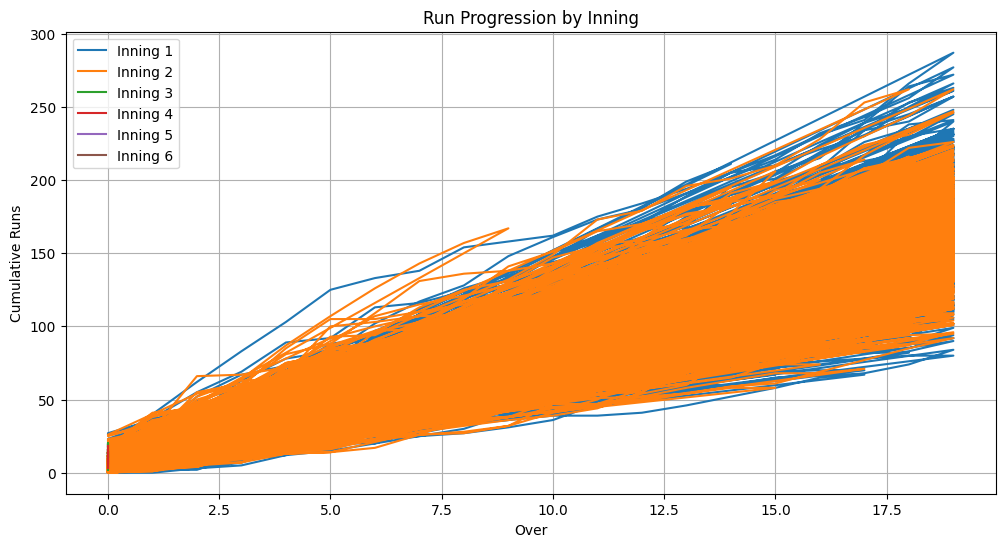

In [27]:

# Create run rate progression by over
over_progress = cricket_df.groupby(['match_id', 'inning', 'over']).agg({
    'total_runs': 'sum',
    'is_wicket': 'sum'
}).reset_index()

print("Over progression summary:")
print(over_progress.head())

# Group by match and inning to see match progression
# Using custom aggregation for cumulative sums
match_progress = over_progress.groupby(['match_id', 'inning']).apply(
    lambda x: pd.DataFrame({
        'over': x['over'],
        'cum_runs': x['total_runs'].cumsum(),
        'cum_wickets': x['is_wicket'].cumsum()
    })
).reset_index()

print("\nMatch progress summary:")
print(match_progress.head())

# Visualization code - for complete data
plt.figure(figsize=(12, 6))
for inning in cricket_df['inning'].unique():
    inning_data = match_progress[match_progress['inning'] == inning]
    if not inning_data.empty:
        plt.plot(inning_data['over'], inning_data['cum_runs'],
                 label=f'Inning {inning}')

plt.xlabel('Over')
plt.ylabel('Cumulative Runs')
plt.title('Run Progression by Inning')
plt.legend()
plt.grid(True)
plt.show()

# **Step 7: Wicket Analysis**

Total wickets in dataset: 12950

Wicket distribution by over:
    over  is_wicket
0      0        463
1      1        503
2      2        533
3      3        548
4      4        576
5      5        540
6      6        444
7      7        472
8      8        537
9      9        498
10    10        568
11    11        567
12    12        585
13    13        633
14    14        695
15    15        736
16    16        779
17    17        976
18    18        989
19    19       1308

Wicket types distribution:
dismissal_kind
caught                   8063
bowled                   2212
run out                  1114
lbw                       800
caught and bowled         367
stumped                   358
retired hurt               15
hit wicket                 15
obstructing the field       3
retired out                 3
Name: count, dtype: int64


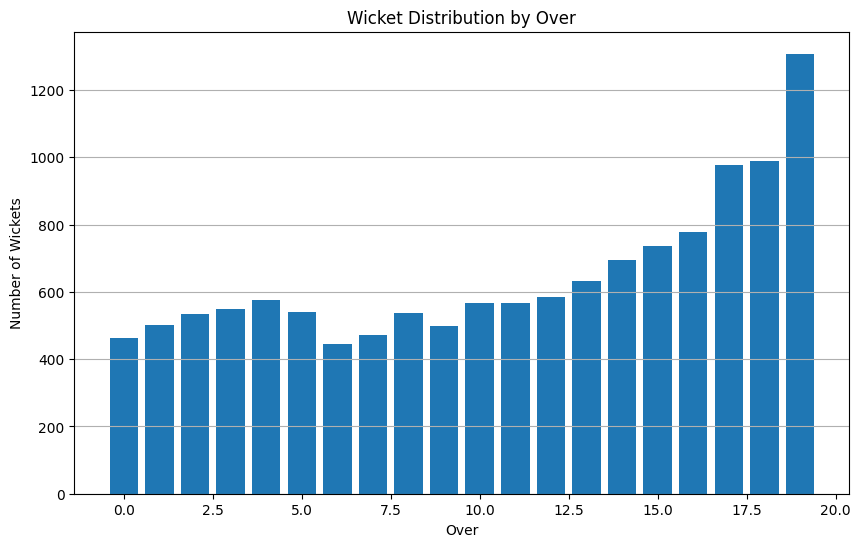

In [28]:
# Wicket Analysis
import pandas as pd
import matplotlib.pyplot as plt

# Count total wickets
wicket_count = cricket_df['is_wicket'].sum()
print(f"Total wickets in dataset: {wicket_count}")

# Create wicket distribution by over
wickets_by_over = cricket_df.groupby('over')['is_wicket'].sum().reset_index()
print("\nWicket distribution by over:")
print(wickets_by_over)

# For datasets with wickets, analyze dismissal types
if wicket_count > 0:
    wicket_data = cricket_df[cricket_df['is_wicket'] == 1]

    # Wicket distribution by dismissal type
    wicket_types = wicket_data['dismissal_kind'].value_counts()
    print("\nWicket types distribution:")
    print(wicket_types)

    # Visualize wicket distribution
    plt.figure(figsize=(10, 6))
    plt.bar(wickets_by_over['over'], wickets_by_over['is_wicket'])
    plt.xlabel('Over')
    plt.ylabel('Number of Wickets')
    plt.title('Wicket Distribution by Over')
    plt.grid(axis='y')
    plt.show()
else:
    print("\nNo wickets in the sample data to analyze dismissal types.")

# **Step 8: Partnership Analysis**

In [29]:
# Partnership Analysis
import pandas as pd

def analyze_partnerships(df):
    """
    Analyze batting partnerships in cricket match data

    Args:
        df: DataFrame with ball-by-ball cricket data

    Returns:
        DataFrame with partnership details
    """
    # Check if we have enough data
    if len(df) <= 1:
        print("Not enough data to identify partnerships")
        return pd.DataFrame()

    # Sort data by match, inning, over and ball
    df = df.sort_values(['match_id', 'inning', 'over', 'ball'])

    partnerships = []
    matches = df['match_id'].unique()

    for match in matches:
        match_data = df[df['match_id'] == match]
        innings = match_data['inning'].unique()

        for inning in innings:
            inning_data = match_data[match_data['inning'] == inning]

            # Track current batters and partnership runs
            partnership_start_idx = 0
            current_batters = [inning_data.iloc[0]['batter'], inning_data.iloc[0]['non_striker']]
            partnership_runs = 0

            for i, ball in inning_data.iterrows():
                # Add runs to current partnership
                partnership_runs += ball['total_runs']

                # Check if wicket fell
                if ball['is_wicket'] == 1 and ball['player_dismissed'] in current_batters:
                    # Record partnership
                    partnership_info = {
                        'match_id': match,
                        'inning': inning,
                        'batters': sorted(current_batters),
                        'partnership_runs': partnership_runs,
                        'balls': i - partnership_start_idx + 1
                    }
                    partnerships.append(partnership_info)

                    # Update batters for next partnership
                    dismissed = ball['player_dismissed']
                    current_batters.remove(dismissed)

                    # Try to find next batter
                    next_ball_idx = i + 1
                    if next_ball_idx < len(inning_data):
                        next_ball = inning_data.iloc[next_ball_idx]
                        new_batters = [next_ball['batter'], next_ball['non_striker']]
                        new_batter = [b for b in new_batters if b not in current_batters]
                        if new_batter:
                            current_batters.append(new_batter[0])

                    # Reset for next partnership
                    partnership_start_idx = i + 1
                    partnership_runs = 0

            # Record final partnership if it has runs
            if partnership_runs > 0:
                partnership_info = {
                    'match_id': match,
                    'inning': inning,
                    'batters': sorted(current_batters),
                    'partnership_runs': partnership_runs,
                    'balls': len(inning_data) - partnership_start_idx
                }
                partnerships.append(partnership_info)

    # Create DataFrame from partnerships list
    if partnerships:
        partnerships_df = pd.DataFrame(partnerships)
        partnerships_df['run_rate'] = (partnerships_df['partnership_runs'] /
                                      partnerships_df['balls']) * 6
        return partnerships_df
    else:
        return pd.DataFrame()

# Apply partnership analysis
partnerships_df = analyze_partnerships(cricket_df)

if not partnerships_df.empty:
    print("Top Partnerships:")
    print(partnerships_df.sort_values('partnership_runs', ascending=False).head(10))
else:
    print("No partnership data available from the sample.")

Top Partnerships:
      match_id  inning                          batters  partnership_runs  \
3220    980987       1                        [V Kohli]               229   
2899    829795       1                        [V Kohli]               215   
6237   1426297       1  [B Sai Sudharsan, Shubman Gill]               210   
5425   1304112       1            [KL Rahul, Q de Kock]               210   
1899    598006       1                               []               208   
5335   1304096       1                      [DA Warner]               207   
1360    501260       1                   [AC Gilchrist]               206   
6123   1426277       1                     [RD Gaikwad]               206   
1793    548372       1                       [CH Gayle]               204   
6080   1426269       2                     [JC Buttler]               202   

       balls   run_rate  
3220      98  14.020408  
2899 -119133  -0.010828  
6237  257960   0.004884  
5425     122  10.327869  
1899

# **Step 9: Visualization of Key Insights**

Runs distribution:
total_runs
0     90438
1    108440
2     17323
3       922
4     30221
5       524
6     12964
7        88
Name: count, dtype: int64


<ipython-input-30-38a37dbaec1b>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='total_runs', data=cricket_df, palette='viridis')


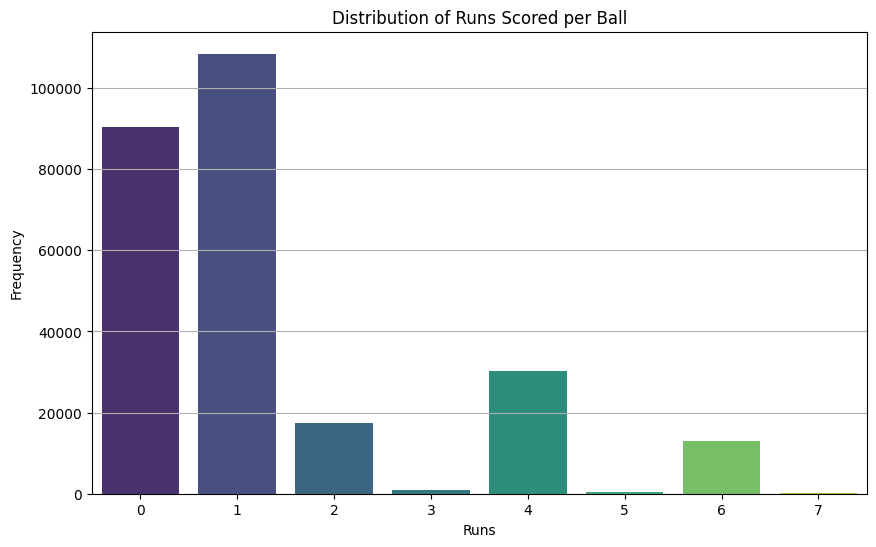

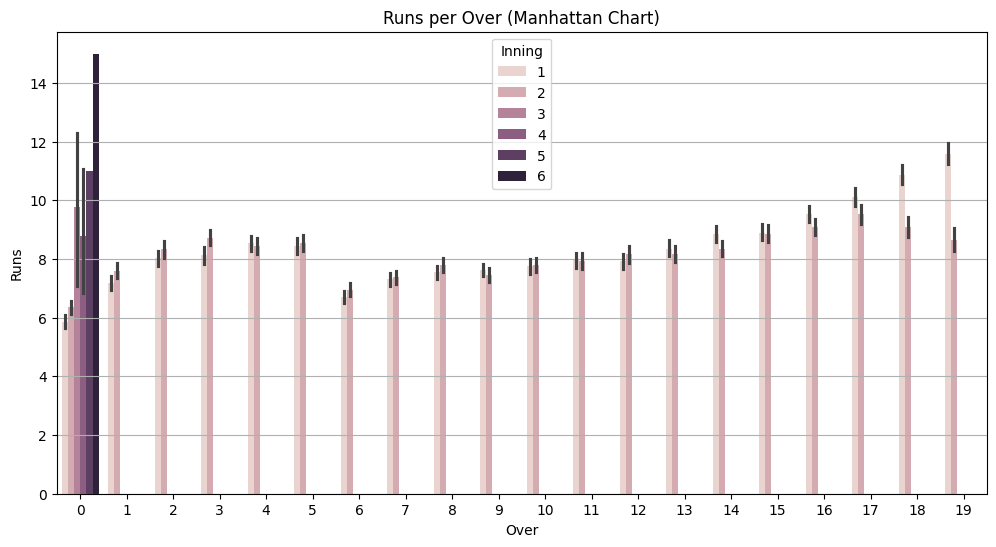


Dot ball percentage: 34.66%
Boundary percentage: 16.44%


In [30]:
# Run Distribution Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Analyze runs per ball
runs_distribution = cricket_df['total_runs'].value_counts().sort_index()
print("Runs distribution:")
print(runs_distribution)

# Visualize runs distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='total_runs', data=cricket_df, palette='viridis')
plt.title('Distribution of Runs Scored per Ball')
plt.xlabel('Runs')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

# Analyze runs by over
runs_by_over = cricket_df.groupby(['match_id', 'inning', 'over'])['total_runs'].sum().reset_index()

# Create Manhattan chart for run rate by over
plt.figure(figsize=(12, 6))
sns.barplot(x='over', y='total_runs', hue='inning', data=runs_by_over)
plt.title('Runs per Over (Manhattan Chart)')
plt.xlabel('Over')
plt.ylabel('Runs')
plt.legend(title='Inning')
plt.grid(axis='y')
plt.show()

# Calculate dot ball percentage
total_balls = len(cricket_df)
dot_balls = len(cricket_df[cricket_df['total_runs'] == 0])
dot_percentage = (dot_balls / total_balls) * 100
print(f"\nDot ball percentage: {dot_percentage:.2f}%")

# Calculate boundary percentage
boundaries = len(cricket_df[cricket_df['batsman_runs'].isin([4, 6])])
boundary_percentage = (boundaries / total_balls) * 100
print(f"Boundary percentage: {boundary_percentage:.2f}%")

# **Step 10: Advanced Analytics & Insights**

#  Player Performance Analysis

Top Batsmen by Runs:
             batter  batsman_runs  is_wicket  match_id  balls_faced  \
631         V Kohli          8014        218       244         6236   
512        S Dhawan          6769        194       221         5483   
477       RG Sharma          6630        232       251         5183   
147       DA Warner          6567        164       184         4849   
546        SK Raina          5536        168       200         4177   
374        MS Dhoni          5243        149       228         3947   
30   AB de Villiers          5181        125       170         3487   
124        CH Gayle          4997        128       141         3516   
501      RV Uthappa          4954        184       197         3927   
282      KD Karthik          4843        189       233         3687   

     batting_avg  strike_rate  matches  fours  sixes  
631    36.761468   128.511867      244  708.0  273.0  
512    34.891753   123.454313      221  768.0  153.0  
477    28.577586   127.918194   

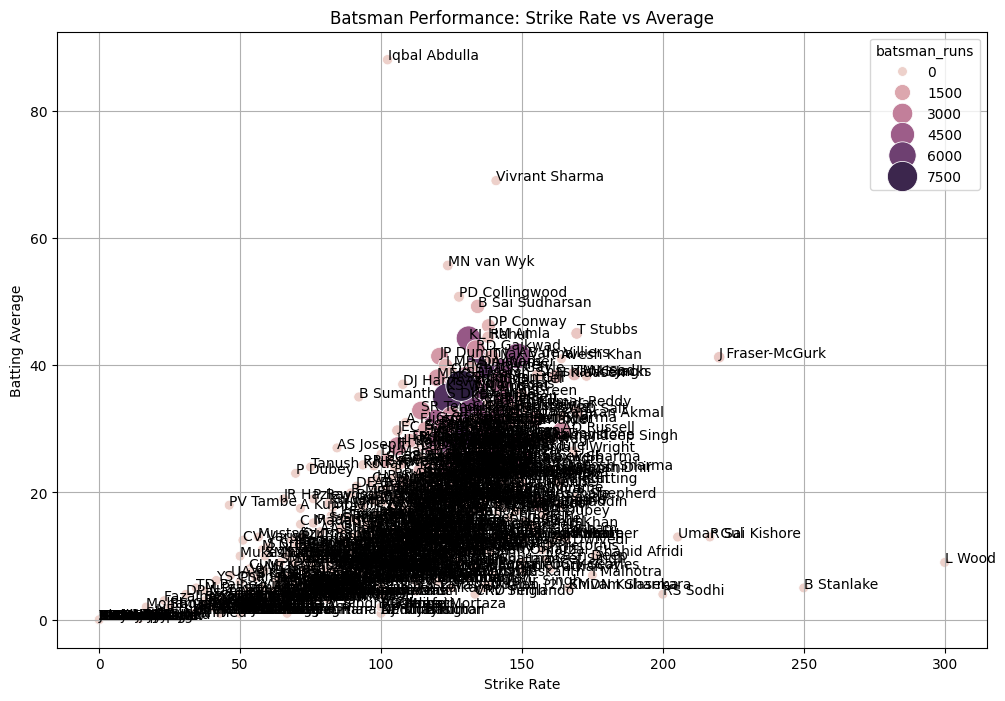

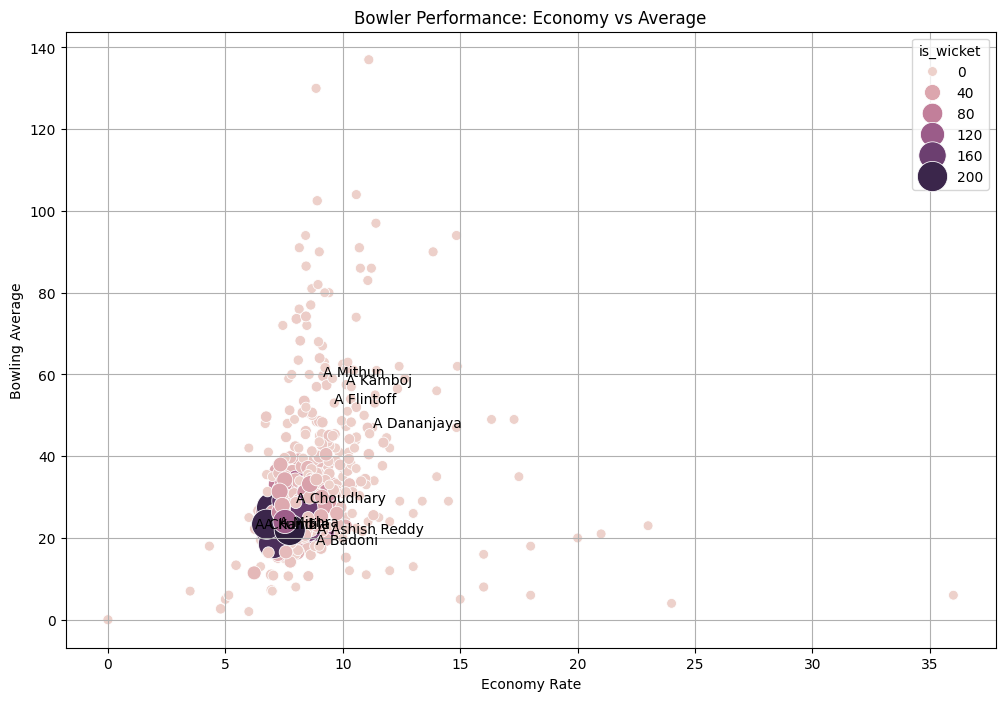

In [31]:
# Player Performance Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Batsman analysis
batsmen = cricket_df.groupby('batter').agg({
    'batsman_runs': 'sum',
    'is_wicket': 'sum',
    'match_id': 'nunique',  # count unique matches
}).reset_index()

# Calculate balls faced per batsman
balls_faced = cricket_df.groupby('batter').size().reset_index(name='balls_faced')
batsmen = pd.merge(batsmen, balls_faced, on='batter')

# Calculate batting statistics
batsmen['batting_avg'] = batsmen['batsman_runs'] / batsmen['is_wicket'].replace(0, 1)
batsmen['strike_rate'] = (batsmen['batsman_runs'] / batsmen['balls_faced']) * 100
batsmen['matches'] = batsmen['match_id']

# Count boundaries
fours = cricket_df[cricket_df['batsman_runs'] == 4].groupby('batter').size().reset_index(name='fours')
sixes = cricket_df[cricket_df['batsman_runs'] == 6].groupby('batter').size().reset_index(name='sixes')

# Merge boundary counts
batsmen = pd.merge(batsmen, fours, on='batter', how='left')
batsmen = pd.merge(batsmen, sixes, on='batter', how='left')
batsmen['fours'] = batsmen['fours'].fillna(0)
batsmen['sixes'] = batsmen['sixes'].fillna(0)

print("Top Batsmen by Runs:")
print(batsmen.sort_values('batsman_runs', ascending=False).head(10))

# Bowler analysis
bowlers = cricket_df.groupby('bowler').agg({
    'total_runs': 'sum',
    'is_wicket': 'sum',
    'match_id': 'nunique',  # count unique matches
}).reset_index()

# Calculate balls bowled per bowler
balls_bowled = cricket_df.groupby('bowler').size().reset_index(name='balls_bowled')
bowlers = pd.merge(bowlers, balls_bowled, on='bowler')

# Calculate bowling statistics
bowlers['overs'] = bowlers['balls_bowled'] / 6
bowlers['economy'] = bowlers['total_runs'] / bowlers['overs']
bowlers['bowling_avg'] = bowlers['total_runs'] / bowlers['is_wicket'].replace(0, 1)
bowlers['bowling_sr'] = bowlers['balls_bowled'] / bowlers['is_wicket'].replace(0, 1)
bowlers['matches'] = bowlers['match_id']

print("\nTop Bowlers by Wickets:")
print(bowlers.sort_values('is_wicket', ascending=False).head(10))

# Visualize player performance
if len(batsmen) > 1:
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='strike_rate', y='batting_avg', size='batsman_runs',
                    hue='batsman_runs', data=batsmen, sizes=(50, 500))
    plt.title('Batsman Performance: Strike Rate vs Average')
    plt.xlabel('Strike Rate')
    plt.ylabel('Batting Average')
    for i, row in batsmen.iterrows():
        plt.annotate(row['batter'], (row['strike_rate'], row['batting_avg']))
    plt.grid(True)
    plt.show()

if len(bowlers) > 1:
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='economy', y='bowling_avg', size='is_wicket',
                    hue='is_wicket', data=bowlers, sizes=(50, 500))
    plt.title('Bowler Performance: Economy vs Average')
    plt.xlabel('Economy Rate')
    plt.ylabel('Bowling Average')
    for i, row in bowlers.head(10).iterrows():
        plt.annotate(row['bowler'], (row['economy'], row['bowling_avg']))
    plt.grid(True)
    plt.show()

# **Step 11: Match-up Analysis**

In [32]:
# Match-up Analysis
import pandas as pd

# Analyze batsman vs bowler match-ups
matchups = cricket_df.groupby(['batter', 'bowler']).agg({
    'batsman_runs': 'sum',
    'is_wicket': 'sum',
    'match_id': 'nunique',  # count unique matches
}).reset_index()

# Calculate balls bowled in each match-up
balls_in_matchup = cricket_df.groupby(['batter', 'bowler']).size().reset_index(name='balls')
matchups = pd.merge(matchups, balls_in_matchup, on=['batter', 'bowler'])

# Calculate match-up statistics
matchups['strike_rate'] = (matchups['batsman_runs'] / matchups['balls']) * 100
matchups['dismissal_rate'] = matchups['is_wicket'] / matchups['balls']
matchups['dominance_ratio'] = matchups['batsman_runs'] / (matchups['is_wicket'] * 10 + 1)  # Higher value means batsman dominates

# Filter for significant match-ups (minimum balls faced)
significant_matchups = matchups[matchups['balls'] >= 6]  # At least 1 over

print("Significant Batsman-Bowler Match-ups:")
print(significant_matchups.sort_values('balls', ascending=False).head(10))

print("\nMatch-ups where Bowler Dominates:")
print(significant_matchups.sort_values('dominance_ratio').head(5))

print("\nMatch-ups where Batsman Dominates:")
print(significant_matchups.sort_values('dominance_ratio', ascending=False).head(5))

Significant Batsman-Bowler Match-ups:
          batter           bowler  batsman_runs  is_wicket  match_id  balls  \
26199    V Kohli         R Ashwin           179          1        22    153   
26208    V Kohli        RA Jadeja           157          5        19    148   
19788  RG Sharma        SP Narine           143          9        21    136   
5481   DA Warner        SP Narine           195          2        16    127   
11655   KL Rahul        JJ Bumrah           150          3        13    126   
22427   SK Raina  Harbhajan Singh           132          5        19    125   
21179   S Dhawan  Harbhajan Singh           147          4        15    123   
19809  RG Sharma         UT Yadav           170          5        17    121   
5438   DA Warner         R Ashwin           122          4        14    118   
26240    V Kohli        SP Narine           127          4        16    118   

       strike_rate  dismissal_rate  dominance_ratio  
26199   116.993464        0.006536    

# **Step 12: Team Performance Analysis**

Team Batting Performance:
                   batting_team  total_runs  is_wicket  match_id  balls_faced  \
17  Royal Challengers Bengaluru        2930         99        15         1818   
5                Gujarat Titans        7757        247        45         5494   
12                 Punjab Kings        9536        371        56         6833   
9          Lucknow Super Giants        7510        276        44         5400   
4                 Gujarat Lions        4862        188        30         3566   
2                Delhi Capitals       14900        570        91        10946   
0           Chennai Super Kings       38629       1245       237        28651   
10               Mumbai Indians       42176       1573       261        31437   
16  Royal Challengers Bangalore       37692       1384       240        28205   
8         Kolkata Knight Riders       39331       1491       251        29514   
18          Sunrisers Hyderabad       29071       1058       182        21843   
6 

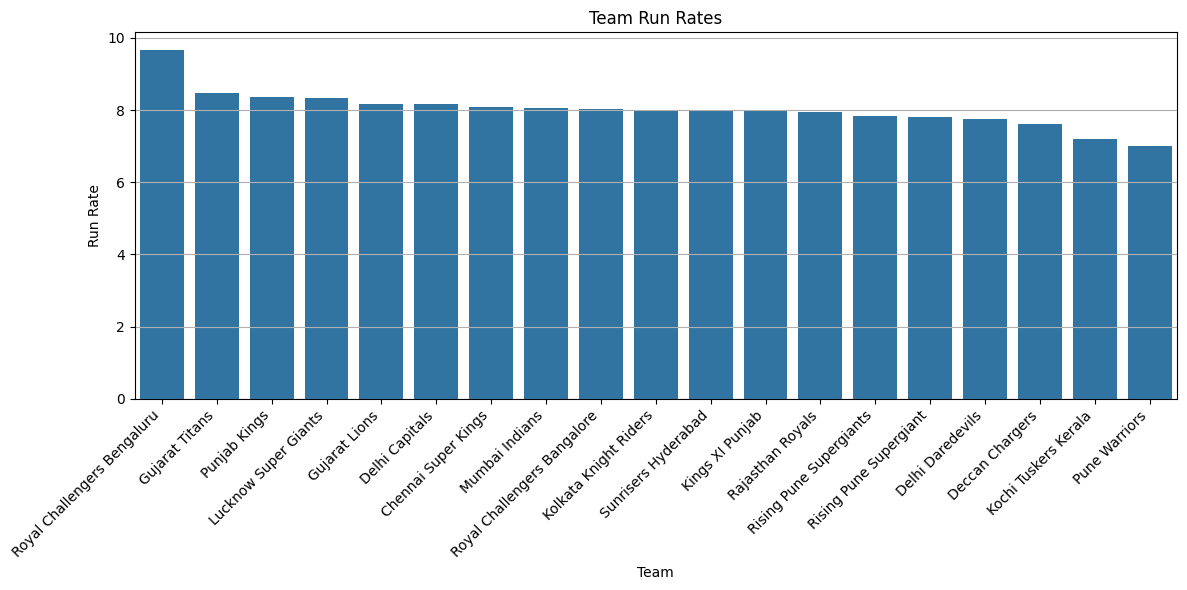

In [33]:
# Team Performance Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Team batting performance
team_batting = cricket_df.groupby('batting_team').agg({
    'total_runs': 'sum',
    'is_wicket': 'sum',
    'match_id': 'nunique',  # count unique matches
}).reset_index()

# Calculate team batting statistics
team_balls = cricket_df.groupby('batting_team').size().reset_index(name='balls_faced')
team_batting = pd.merge(team_batting, team_balls, on='batting_team')

team_batting['run_rate'] = (team_batting['total_runs'] / team_balls['balls_faced']) * 6
team_batting['batting_avg'] = team_batting['total_runs'] / team_batting['is_wicket'].replace(0, 1)

# Count boundaries by team
team_fours = cricket_df[cricket_df['batsman_runs'] == 4].groupby('batting_team').size().reset_index(name='fours')
team_sixes = cricket_df[cricket_df['batsman_runs'] == 6].groupby('batting_team').size().reset_index(name='sixes')

# Merge boundary counts
team_batting = pd.merge(team_batting, team_fours, on='batting_team', how='left')
team_batting = pd.merge(team_batting, team_sixes, on='batting_team', how='left')
team_batting['fours'] = team_batting['fours'].fillna(0)
team_batting['sixes'] = team_batting['sixes'].fillna(0)
team_batting['boundary_percentage'] = ((team_batting['fours'] + team_batting['sixes']) / team_batting['balls_faced']) * 100

print("Team Batting Performance:")
print(team_batting.sort_values('run_rate', ascending=False))

# Team bowling performance
team_bowling = cricket_df.groupby('bowling_team').agg({
    'total_runs': 'sum',
    'is_wicket': 'sum',
    'match_id': 'nunique',  # count unique matches
}).reset_index()

# Calculate team bowling statistics
team_balls_bowled = cricket_df.groupby('bowling_team').size().reset_index(name='balls_bowled')
team_bowling = pd.merge(team_bowling, team_balls_bowled, on='bowling_team')

team_bowling['economy_rate'] = (team_bowling['total_runs'] / team_bowling['balls_bowled']) * 6
team_bowling['bowling_avg'] = team_bowling['total_runs'] / team_bowling['is_wicket'].replace(0, 1)
team_bowling['bowling_sr'] = team_bowling['balls_bowled'] / team_bowling['is_wicket'].replace(0, 1)

print("\nTeam Bowling Performance:")
print(team_bowling.sort_values('economy_rate'))

# Visualize team comparison
if len(team_batting) > 1:
    plt.figure(figsize=(12, 6))
    sns.barplot(x='batting_team', y='run_rate', data=team_batting.sort_values('run_rate', ascending=False))
    plt.title('Team Run Rates')
    plt.xlabel('Team')
    plt.ylabel('Run Rate')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()